In [29]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.utils.class_weight import compute_class_weight
from sklearn.calibration import CalibratedClassifierCV
import re
import string
from nltk.corpus import stopwords
import nltk
from nltk.stem import SnowballStemmer

# Download NLTK stopwords if not already present
nltk.download('stopwords')

# Initialize stemmers
english_stemmer = SnowballStemmer('english')
def swahili_stemmer(word=None):
    suffixes = ['ni', 'wa', 'ya', 'ku', 'ka', 'a', 'e']
    if word:
        for suffix in suffixes:
            if word.endswith(suffix):
                return [word[:-len(suffix)], suffixes]
    return [word, suffixes]
# Load your dataset
# Replace with your actual file path
df = pd.read_csv('diseases.csv')  # Assuming columns: 'transcript', 'disease'

# Display first few rows
print(df.head())
print("\nDataset shape:", df.shape)
print("\nClass distribution:")
print(df['disease'].value_counts())

                         description disease
0                 Frequent urination     UTI
1   Naenda choo kidogo mara kwa mara     UTI
2         Always feeling like peeing     UTI
3           Kukojoa kila dakika tano     UTI
4  Burning sensation while urinating     UTI

Dataset shape: (374, 2)

Class distribution:
disease
UTI        134
Malaria    125
Typhoid    115
Name: count, dtype: int64


[nltk_data] Downloading package stopwords to
[nltk_data]     /home/tarxemo/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [30]:
df.head()

,description,disease
0,Frequent urination,UTI
1,Naenda choo kidogo mara kwa mara,UTI
2,Always feeling like peeing,UTI
3,Kukojoa kila dakika tano,UTI
4,Burning sensation while urinating,UTI


In [33]:
from fuzzywuzzy import fuzz
import distance
from collections import defaultdict
import re
from nltk.stem import SnowballStemmer

# Initialize stemmers
english_stemmer = SnowballStemmer('english')

# Combined stopwords (English + Swahili)
combined_stopwords = set(stopwords.words('english')).union(swahili_stemmer()[1])

def build_combined_vocabulary(text_series):
    """Build a unified frequency dictionary of stemmed words"""
    vocab = defaultdict(int)
    for text in text_series:
        words = text.lower().split()
        for word in words:
            # Try both stemmers and keep both versions
            eng_stem = english_stemmer.stem(word)
            swa_stem = swahili_stemmer(word)[0]
            vocab[eng_stem] += 1
            vocab[swa_stem] += 1
    return vocab

# Build combined vocabulary
combined_vocab = build_combined_vocabulary(df['description'])

def find_closest_word_combined(word, threshold=70):
    """
    Language-agnostic word correction using combined metrics
    """
    if word in combined_vocab:
        return word
    
    # Get stems using both stemmers
    eng_stem = english_stemmer.stem(word)
    swa_stem = swahili_stemmer(word)[0]
    
    best_match = word
    best_score = 0
    
    for vocab_word, freq in combined_vocab.items():
        # Calculate multiple similarity metrics
        edit_sim = 1 - (distance.levenshtein(word, vocab_word) / max(len(word), len(vocab_word)))
        phonetic_sim = fuzz.ratio(word, vocab_word) / 100
        
        # Calculate stem similarity with both stemmers
        stem_sim = max(
            fuzz.ratio(eng_stem, english_stemmer.stem(vocab_word)) / 100,
            fuzz.ratio(swa_stem, swahili_stemmer(vocab_word)[0]) / 100
        )
        
        # Combined weighted score
        combined_score = (edit_sim * 0.4 + phonetic_sim * 0.3 + stem_sim * 0.3) * (1 + np.log1p(freq))
        
        if combined_score > best_score:
            best_score = combined_score
            best_match = vocab_word
    
    return best_match if best_score * 100 > threshold else word

def language_agnostic_preprocess(text):
    # Convert to lowercase
    text = text.lower()
    
    # Remove punctuation (keeping apostrophes)
    text = re.sub(r'[^\w\s\']', '', text)
    
    # Tokenize
    words = text.split()
    
    processed_words = []
    for word in words:
        # Skip stopwords
        if word in combined_stopwords:
            continue
        
        # Auto-correct the word
        corrected_word = find_closest_word_combined(word)
        
        # Stem with both stemmers (model will learn to handle both)
        eng_stem = english_stemmer.stem(corrected_word)
        swa_stem = swahili_stemmer(corrected_word)[0]
        
        # Keep both stems separated by special token
        processed_words.append(f"{eng_stem}_{swa_stem}")
    
    return ' '.join(processed_words)

# Apply preprocessing
df['processed_text'] = df['description'].apply(language_agnostic_preprocess)

# Display samples
print("\nLanguage-Agnostic Preprocessing Samples:")
for i in range(5):
    original = df['description'].iloc[i]
    processed = df['processed_text'].iloc[i]
    print(f"Original: {original}")
    print(f"Processed: {processed}")
    print("-" * 50)


Language-Agnostic Preprocessing Samples:
Original: Frequent urination
Processed: frequent_frequent urin_urination
--------------------------------------------------
Original: Naenda choo kidogo mara kwa mara
Processed: naenda_naend choo_choo kidogo_kidogo mara_mar kwa_k mara_mar
--------------------------------------------------
Original: Always feeling like peeing
Processed: alway_always feel_feeling like_lik pee_peeing
--------------------------------------------------
Original: Kukojoa kila dakika tano
Processed: kukojoa_kukojo kila_kil dakika_daki tano_tano
--------------------------------------------------
Original: Burning sensation while urinating
Processed: burn_burning sensat_sensation urin_urinating
--------------------------------------------------


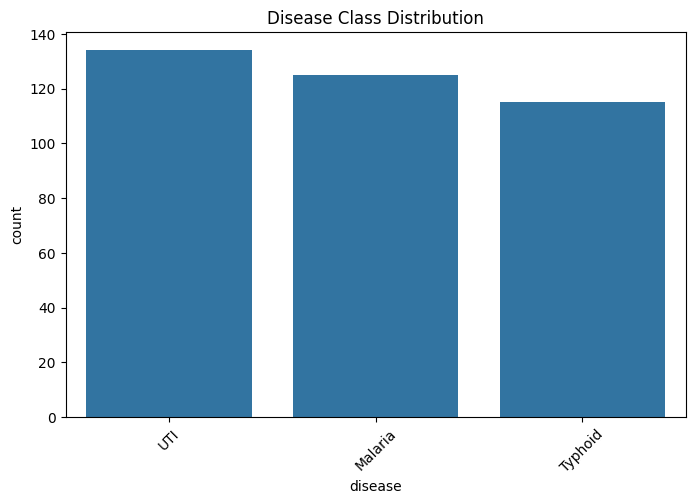


Class counts: disease
UTI        134
Malaria    125
Typhoid    115
Name: count, dtype: int64

Class weights: {'UTI': np.float64(0.9303482587064676), 'Malaria': np.float64(0.9973333333333333), 'Typhoid': np.float64(1.0840579710144929)}


In [34]:
# Check class distribution
plt.figure(figsize=(8,5))
sns.countplot(data=df, x='disease')
plt.title('Disease Class Distribution')
plt.xticks(rotation=45)
plt.show()

# If classes are imbalanced, we'll handle this during model training
class_counts = df['disease'].value_counts()
print("\nClass counts:", class_counts)

# Calculate class weights for balancing
classes = df['disease'].unique()
class_weights = compute_class_weight('balanced', classes=classes, y=df['disease'])
class_weight_dict = dict(zip(classes, class_weights))
print("\nClass weights:", class_weight_dict)

In [35]:
# Initialize TF-IDF vectorizer with parameters suitable for both languages
tfidf = TfidfVectorizer(
    max_features=5000,
    ngram_range=(1, 2),  # Consider single words and word pairs
    analyzer='word',
    min_df=2,
    max_df=0.8
)

# Fit and transform the processed text
X = tfidf.fit_transform(df['processed_text'])
y = df['disease']

# Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"\nTraining set shape: {X_train.shape}")
print(f"Test set shape: {X_test.shape}")


Training set shape: (299, 346)
Test set shape: (75, 346)


In [36]:
# Initialize models
models = {
    'Naive Bayes': MultinomialNB(),
    'Random Forest': RandomForestClassifier(
        class_weight=class_weight_dict,
        random_state=42,
        n_estimators=100
    ),
    'SVM': CalibratedClassifierCV(
        SVC(
            kernel='linear',
            class_weight=class_weight_dict,
            probability=True
        )
    )
}

# Train and evaluate models
results = {}
for name, model in models.items():
    print(f"\nTraining {name}...")
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    
    # Store results
    results[name] = {
        'accuracy': accuracy_score(y_test, y_pred),
        'report': classification_report(y_test, y_pred),
        'model': model
    }
    
    # Print results
    print(f"{name} Accuracy: {accuracy_score(y_test, y_pred):.2f}")
    print("Classification Report:")
    print(classification_report(y_test, y_pred))


Training Naive Bayes...
Naive Bayes Accuracy: 0.81
Classification Report:
              precision    recall  f1-score   support

     Malaria       0.76      0.76      0.76        25
     Typhoid       0.76      0.70      0.73        23
         UTI       0.90      0.96      0.93        27

    accuracy                           0.81        75
   macro avg       0.81      0.81      0.81        75
weighted avg       0.81      0.81      0.81        75


Training Random Forest...
Random Forest Accuracy: 0.81
Classification Report:
              precision    recall  f1-score   support

     Malaria       0.70      0.84      0.76        25
     Typhoid       0.84      0.70      0.76        23
         UTI       0.92      0.89      0.91        27

    accuracy                           0.81        75
   macro avg       0.82      0.81      0.81        75
weighted avg       0.82      0.81      0.81        75


Training SVM...
SVM Accuracy: 0.81
Classification Report:
              precision  


Model Comparison:
Naive Bayes: Accuracy = 0.81
Random Forest: Accuracy = 0.81
SVM: Accuracy = 0.81

Selected best model: Naive Bayes


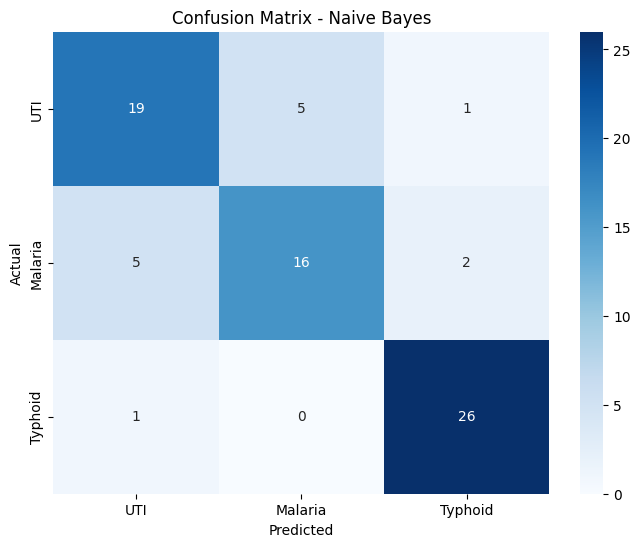

In [37]:
# Compare model performance
print("\nModel Comparison:")
for name, result in results.items():
    print(f"{name}: Accuracy = {result['accuracy']:.2f}")

# Select best model based on your preferred metric
best_model_name = max(results, key=lambda x: results[x]['accuracy'])
best_model = results[best_model_name]['model']
print(f"\nSelected best model: {best_model_name}")

# Plot confusion matrix for best model
y_pred_best = best_model.predict(X_test)
cm = confusion_matrix(y_test, y_pred_best)

plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=classes, yticklabels=classes)
plt.title(f'Confusion Matrix - {best_model_name}')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

In [45]:
# We'll add a probability threshold to detect irrelevant inputs
def predict_with_threshold(model, text_vector, threshold=0.5):
    probs = model.predict_proba(text_vector)
    max_prob = np.max(probs)
    if max_prob < threshold:
        return "irrelevant_input"
    return model.predict(text_vector)[0]

# Test with some examples
test_texts = [
    "ninakula wali",  # Swahili for "I'm eating rice" - irrelevant
    "naumwa tumbo",  # Swahili for "I have a headache" - relevant
    "i have fever",   # English relevant
    "i went shopping" # English irrelevant
]

for text in test_texts:
    processed = language_agnostic_preprocess(text)
    vector = tfidf.transform([processed])
    prediction = predict_with_threshold(best_model, vector)
    print(f"Text: '{text}' -> Prediction: '{prediction}'")

Text: 'ninakula wali' -> Prediction: 'Typhoid'
Text: 'naumwa tumbo' -> Prediction: 'irrelevant_input'
Text: 'i have fever' -> Prediction: 'irrelevant_input'
Text: 'i went shopping' -> Prediction: 'irrelevant_input'
